In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from astropy.io import fits
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.visualization import (MinMaxInterval,SqrtStretch,ZScaleInterval,PercentileInterval,ImageNormalize)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch
from itertools import repeat
from matplotlib.colors import LogNorm
import os
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.stats import norm
import pickle
from tools.equivalentWidth import *

libradtranpath= /home/joseph/libRadtran/


# Now we condense the whole process and iterate on dates

In [2]:
############################################
## Initialise data and formatting options ##
##      May be improved or automated      ##
############################################
inputdir = '../../AuxTelComm/notebookccdm_gen3/bouguerlines/2022_09/data/'
file_label = 'run-auxtel-holo-{0}-{1}~{2}-config_DECONVOLUTION_PSF1D.pickle' #ou PSF2DFFM ou PSF2D
outdir = './output_files/'

'''
bad_spec_dict = {'20220628':[171,223,250,251,400,425,479,480,538,593,654,655,656,657,683,708],
                 '20220629':[206,304,305,418,420,451,504],
                 '20220630':[50,126,181,182,220,356,410,440,454,455,480,525,566,593]}
'''

bad_spec_dict = {'20220629':[206,304,305,418,420,451,504],
                 '20220630':[50,126,181,182,220,356,410,440,454,455,480,525,566,593, 594]}

if not os.path.exists(outdir):
    os.mkdir(outdir)

obs_dates = bad_spec_dict.keys() #np.array(['20220628', '20220629', '20220630'])
filter_ = 'FELH0600'
disperser = 'holo4_003'
save_txt = True

markerCols = ['green', 'blue', 'red']
errbarCols = ['limegreen', 'cyan', 'magenta']
markerStyle = ['x', 'o', 'v']

abs_min, abs_max = 870.0, 1040.0

Widest band identified for exposure No. 87, std HD142331, air mass=1.1648
Lower limit for continuum identified for exposure No. 87, std HD142331, air mass=1.1648
Lower limit for band identified for exposure No. 87, std HD142331, air mass=1.1648
Upper limit for band identified for exposure No. 87, std HD142331, air mass=1.1648
Upper limit for continuum identified for exposure No. 87, std HD142331, air mass=1.1648
Upper limit for band identified for exposure No. 171, std HD142331, air mass=1.0876
Lower limit for continuum identified for exposure No. 363, std HD185975, air mass=1.8675
Lower limit for band identified for exposure No. 363, std HD185975, air mass=1.8675
Widest band identified for exposure No. 366, std HD185975, air mass=1.8667
Lower limit for continuum identified for exposure No. 366, std HD185975, air mass=1.8667
Lower limit for band identified for exposure No. 366, std HD185975, air mass=1.8667
Widest band identified for exposure No. 453, std HD142331, air mass=1.5292
Lowe

Text(0.5, 0.98, 'Equivalent width calculation with a gaussian absorption band to constraint the continuum law fit')

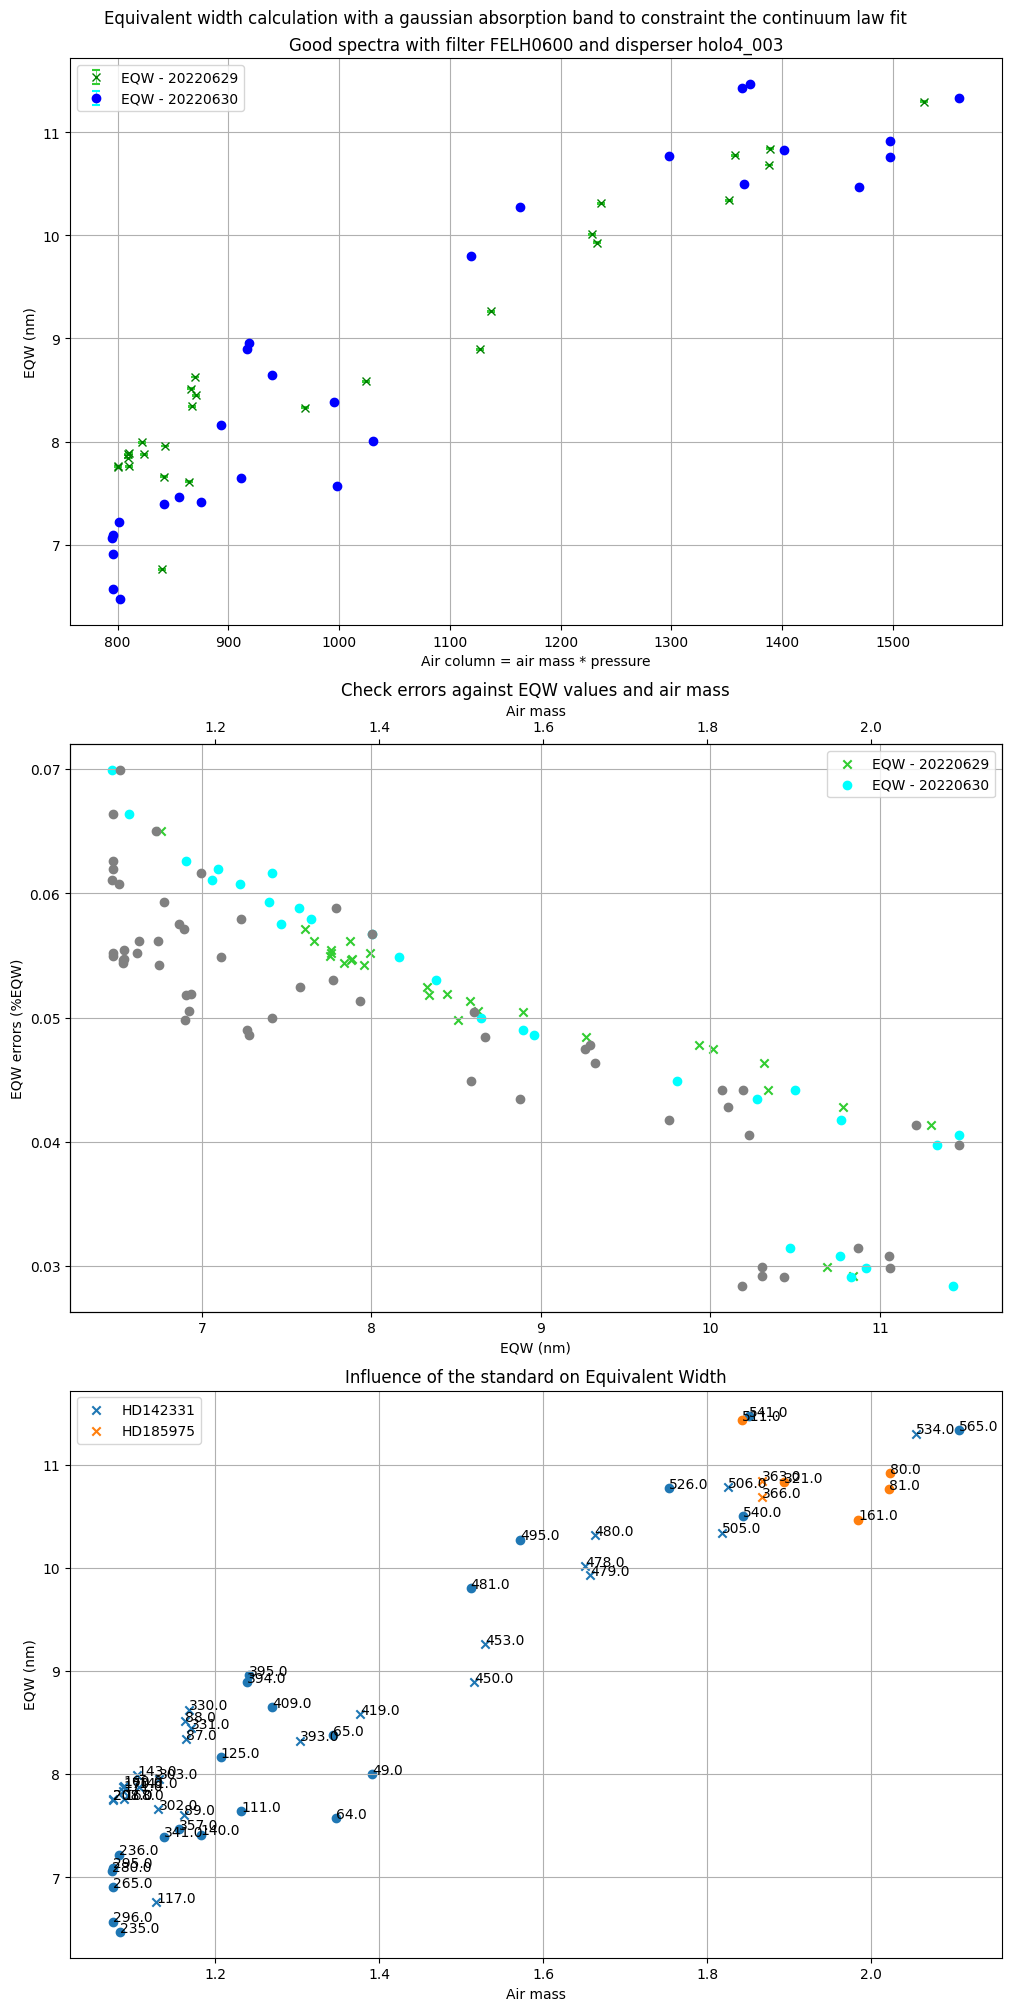

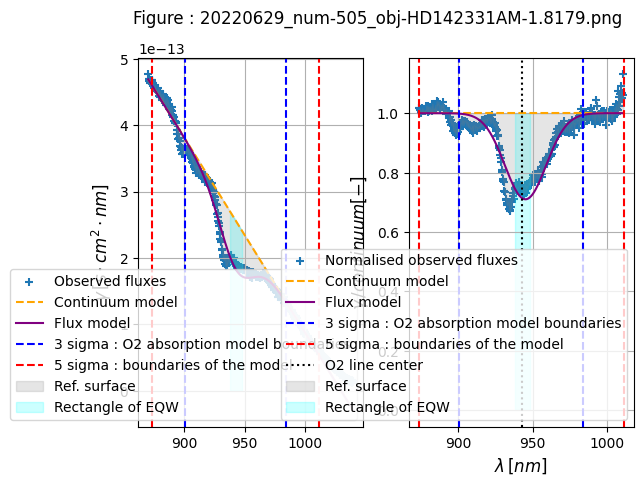

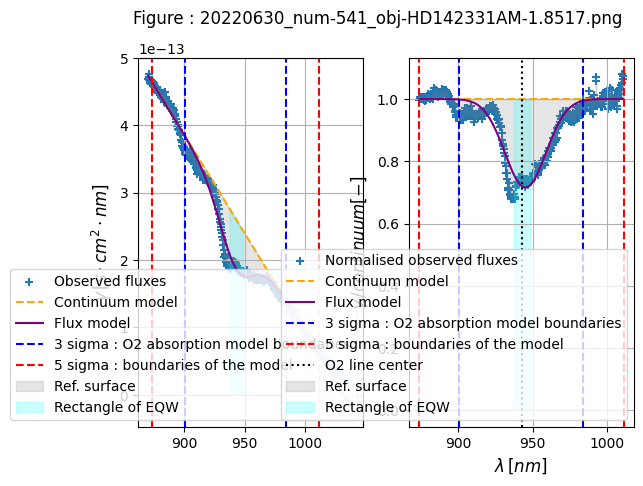

In [3]:
#########################################    
## Run everything and iterate on dates ##
#########################################
fig, axs = plt.subplots(3, 1, figsize=(10,20), constrained_layout=True)
axs = axs.ravel()

all_airmasses = np.empty_like([])
all_pressures = np.empty_like([])
all_eqws = np.empty_like([])
all_eqwerrs = np.empty_like([])
all_area_c_errs = np.empty_like([])
all_cont_errs = np.empty_like([])
all_area_ul_errs = np.empty_like([])
all_area_l_errs = np.empty_like([])
all_numbers = np.empty_like([])
all_objects = np.empty_like([])
targetList = []

maxSigma = 0.
refO2 = 950.
gaussMod, gaussCov = np.empty_like([]), np.empty_like([])
borneInf_cont, borneInf_band, borneSup_band, borneSup_cont = refO2, refO2, refO2, refO2

for obs_date in obs_dates:
    inputfile = os.path.join( inputdir, file_label.format(obs_date, filter_, disperser) )
    with open(inputfile,'rb') as f:
        spec_dict = pickle.load(f)
    
    bad_spec = bad_spec_dict[obs_date]

    spec_dict_good = {}
    for key in spec_dict.keys():
        if int(spec_dict[key]['number']) not in bad_spec:
            spec_dict_good[key] = spec_dict[key]
            
    for spec in spec_dict_good:
        lambda_ = spec_dict_good[spec]['all_lambdas']
        flux_ = spec_dict_good[spec]['all_fluxes']
        flux_err_ = spec_dict_good[spec]['all_fluxes_err']
        
        gaussMod_, cov, lims_ = fit_gaussian(lambda_, flux_, abs_min, abs_max, sigma_flux=flux_err_, central_lambda=refO2)
        if gaussMod_[3] > maxSigma:
            maxSigma = gaussMod_[3]
            refO2 = gaussMod_[2]
            gaussMod = gaussMod_
            gaussCov = cov
            print("Widest band identified for exposure No. {:.0f}, std {}, air mass={:.4f}".format(spec_dict_good[spec]['number'], spec_dict_good[spec]['object'], spec_dict_good[spec]['airmass']))
        if lims_[0] < borneInf_cont:
            borneInf_cont = lims_[0]
            print("Lower limit for continuum identified for exposure No. {:.0f}, std {}, air mass={:.4f}".format(spec_dict_good[spec]['number'], spec_dict_good[spec]['object'], spec_dict_good[spec]['airmass']))
        if lims_[1] < borneInf_band:
            borneInf_band = lims_[1]
            print("Lower limit for band identified for exposure No. {:.0f}, std {}, air mass={:.4f}".format(spec_dict_good[spec]['number'], spec_dict_good[spec]['object'], spec_dict_good[spec]['airmass']))
        if lims_[2] > borneSup_band:
            borneSup_band = lims_[2]
            print("Upper limit for band identified for exposure No. {:.0f}, std {}, air mass={:.4f}".format(spec_dict_good[spec]['number'], spec_dict_good[spec]['object'], spec_dict_good[spec]['airmass']))
        if lims_[3] > borneSup_cont:
            borneSup_cont = lims_[3]
            print("Upper limit for continuum identified for exposure No. {:.0f}, std {}, air mass={:.4f}".format(spec_dict_good[spec]['number'], spec_dict_good[spec]['object'], spec_dict_good[spec]['airmass']))
        lims = np.array([borneInf_cont, borneInf_band, borneSup_band, borneSup_cont])
_loc=-1
for obs_date, mstyle, mcol, ecol in zip(obs_dates, markerStyle, markerCols, errbarCols):
    _loc += 1
    inputfile = os.path.join( inputdir, file_label.format(obs_date, filter_, disperser) )
    with open(inputfile,'rb') as f:
        spec_dict = pickle.load(f)
    
    bad_spec = bad_spec_dict[obs_date]

    spec_dict_good = {}
    for key in spec_dict.keys():
        if int(spec_dict[key]['number']) not in bad_spec:
            spec_dict_good[key] = spec_dict[key]

    #ref_obs = 'exposure_2022062800143_postisrccd_spectrum.fits'
    #lambda_ref = spec_dict_good[ref_obs]['all_lambdas']
    #flux_ref = spec_dict_good[ref_obs]['all_fluxes']

    airmass = np.empty_like([])
    pressure = np.empty_like([])
    eqwidths = np.empty_like([])
    eqw_errs = np.empty_like([])
    numbers = np.empty_like([])
    objects = np.empty_like([])
    loc=-1
    for spec in spec_dict_good:
        loc += 1
        airmass_ = spec_dict_good[spec]['airmass']
        pressure_ = spec_dict_good[spec]['pressure']
        lambda_ = spec_dict_good[spec]['all_lambdas']
        flux_ = spec_dict_good[spec]['all_fluxes']
        flux_err_ = spec_dict_good[spec]['all_fluxes_err']
        expNum_ = spec_dict_good[spec]['number']
        object_ = spec_dict_good[spec]['object']
        if not object_ in targetList:
            targetList.append(object_)

        '''
        if loc%10 == 0 :
            eqw_, eqw_err_, mod, cov, xline, fline, xcontinuum, cont_at_line, area_l_, area_c_err_ = eqw_norm(lambda_, flux_, abs_min, abs_max, make_plot=True, return_fit=True, plot_name="{}_AM-{:.4f}.png".format(obs_date, airmass_))
        else:
            eqw_, eqw_err_, mod, cov, xline, fline, xcontinuum, cont_at_line, area_l_, area_c_err_ = eqw_norm(lambda_, flux_, abs_min, abs_max, make_plot=False, return_fit=True)
        '''
        
        #if loc%10 == 0 :
        if expNum_ in [505, 541, 594]:
            eqw_, bandWidth, eqw_err_, spectrum, continnum, limits = eqw_norm(lambda_, flux_, abs_min, abs_max, sigma_flux=flux_err_, gaussMod_band=gaussMod, limits=lims, fit_band=False, make_plot=True, return_fit=True, plot_name="{}_num-{:.0f}_obj-{}AM-{:.4f}.png".format(obs_date, expNum_, object_, airmass_))
        else:
            eqw_, bandWidth, eqw_err_, spectrum, continnum, limits = eqw_norm(lambda_, flux_, abs_min, abs_max, sigma_flux=flux_err_, gaussMod_band=gaussMod, limits=lims, fit_band=False, make_plot=False, return_fit=True)

        '''
        if eqwdb_<0.:
            print(seqn)
            plot_name_ = 'fit_line_{0}_eqw0.png'.format(seqn)
            eqwdb_ = eqw(x_,flux0,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
        elif eqwdf_<0.:
            print(seqn)
            plot_name_ = 'fit_line_{0}_eqwdf.png'.format(seqn)
            eqwdf_ = eqw(x_,fluxdf,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)

        plot_name_ = 'fit_line_{0}_eqw0.png'.format(seqn)
        eqw0_ = eqw(x_,flux0,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)

        plot_name_ = 'fit_line_{0}_eqwdf.png'.format(seqn)
        eqwdf_ = eqw(x_,fluxdf,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
        '''
        
        airmass = np.append(airmass, airmass_)
        pressure = np.append(pressure, pressure_)
        eqwidths = np.append(eqwidths, eqw_)
        eqw_errs = np.append(eqw_errs, eqw_err_)
        numbers = np.append(numbers, expNum_)
        objects = np.append(objects, object_)
        
        all_airmasses = np.append(all_airmasses, airmass_)
        all_pressures = np.append(all_pressures, pressure_)
        all_eqws = np.append(all_eqws, eqw_)
        all_eqwerrs = np.append(all_eqwerrs, eqw_err_)
        #all_area_c_errs = np.append(all_area_c_errs, area_c_err)
        #all_cont_errs = np.append(all_cont_errs, cont_err_)
        #all_area_ul_errs = np.append(all_area_ul_errs, area_ul_err_)
        #all_area_l_errs = np.append(all_area_l_errs, area_l_err_)
        all_numbers = np.append(all_numbers, expNum_)
        all_objects = np.append(all_objects, object_)
    if save_txt:
        data = np.transpose(np.array([numbers, airmass, pressure, eqwidths, eqw_errs]))
        np.savetxt(os.path.join(outdir,'eqw_data_{0}_{1}_{2}.txt'.format(obs_date, filter_, disperser)), data, header='id airmass pressure eqw eqw_err')
    
    targetList = np.array(targetList)
    axs[0].errorbar(airmass*pressure, eqwidths, yerr=eqw_errs, ls='', marker=mstyle, color=mcol, ecolor=ecol, elinewidth=.5, capsize=3, capthick=1.5, label="EQW - {}".format(obs_date))
    axs[1].scatter(eqwidths, 100.*eqw_errs/eqwidths, marker=mstyle, color=ecol, label="EQW - {}".format(obs_date))
    for target,col in zip(targetList, ['tab:blue', 'tab:orange', 'tab:green']):
        if _loc == 0:
            axs[2].scatter(airmass[objects == target], eqwidths[objects == target], marker=mstyle, color=col, label=target)
        else:
            axs[2].scatter(airmass[objects == target], eqwidths[objects == target], marker=mstyle, color=col)

###################
# format the plot #
###################
axs[0].grid()
axs[0].set_xlabel("Air column = air mass * pressure")
axs[0].set_ylabel("EQW (nm)")
axs[0].set_title("Good spectra with filter {} and disperser {}".format(filter_, disperser))
axs[0].legend()

axs11=axs[1].twiny()
axs11.scatter(all_airmasses, 100.*all_eqwerrs/all_eqws, color="gray")
axs11.set_xlabel("Air mass")

axs[1].grid()
axs[1].set_ylabel("EQW errors (%EQW)")
axs[1].set_xlabel("EQW (nm)")
axs[1].set_title("Check errors against EQW values and air mass")
axs[1].legend()

for am, eqw, num in zip(all_airmasses, all_eqws, all_numbers):
    axs[2].text(am, eqw, num)
axs[2].grid()
axs[2].set_ylabel("EQW (nm)")
axs[2].set_xlabel("Air mass")
axs[2].set_title("Influence of the standard on Equivalent Width")
#axs[2].scatter(all_airmasses, np.power(all_eqwerrs, 2.), color="gray", label="total variance")
#axs[2].scatter(all_airmasses, np.power(all_area_l_errs, 2.), color="blue", label="from surface computation")
#axs[2].scatter(all_airmasses, np.power(all_cont_errs*all_eqws, 2.), color="red", label="from continuum estimation")
#axs[2].set_yscale('log')
#axs[2].grid()
#axs[2].set_ylabel("EQW errors (nm)")
#axs[2].set_xlabel("Air mass")
#axs[2].set_title("Check errors against air mass")
axs[2].legend()
fig.suptitle("Equivalent width calculation with a gaussian absorption band to constraint the continuum law fit")

# Attempt to compare to libradtran sim here

In [4]:
import sys
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.interpolate import interp1d
from libradtranpy import libsimulateVisible
from tools.equivalentWidth import *

Success in the step above looks good ! 

In [5]:
matplotlib.rcParams.update({'font.size': 15, 'lines.linewidth': 2, 'lines.markersize': 15})
matplotlib.rcParams["axes.labelsize"]="small"
matplotlib.rcParams["axes.linewidth"]=2.0
matplotlib.rcParams["xtick.major.size"]=8
matplotlib.rcParams["ytick.major.size"]=8
matplotlib.rcParams["ytick.minor.size"]=5
matplotlib.rcParams["xtick.labelsize"]="large"
matplotlib.rcParams["ytick.labelsize"]="large"
matplotlib.rcParams["figure.figsize"]=(12,6)
matplotlib.rcParams['axes.titlesize'] = 15
matplotlib.rcParams['axes.titleweight'] = 'bold'
#matplotlib.rcParams['axes.facecolor'] = 'blue'
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
matplotlib.rcParams['lines.markersize'] = 10  # markersize, in points
matplotlib.rcParams['grid.alpha'] = 1. # transparency, between 0.0 and 1.0
matplotlib.rcParams['grid.linestyle'] = '-' # simple line
matplotlib.rcParams['grid.linewidth'] = 0.4 # in points 
os.getenv('LIBRADTRANDIR')

'/home/joseph/libRadtran'

In [6]:
AMMIN=1
AMMAX=2.3
AMSTEP = 0.1
all_am=np.arange(AMMIN,AMMAX,AMSTEP)
pressure = 0. # use default value
all_pwv=np.arange(0.0, 5., 0.5)
aer=0
ozone=300.
cloudext=0
atmStd='us'
NBOBS=len(all_am)
NBPWM=len(all_pwv)
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange( NBOBS), alpha=1)

h2o_line=gaussMod[2]
print(h2o_line)
sigmaBand_=gaussMod[3]
min_wl, max_wl = abs_min, abs_max
limInf_cont, limInf_band, limSup_band, limSup_cont = h2o_line, h2o_line, h2o_line, h2o_line
gaussianMod, gaussianCov = gaussMod, gaussCov

943.0269123888959


In [7]:
if True:
    all_trans = []
    for index in np.arange(NBOBS):
        am = all_am[index]
        print("simulate index=",index," airmass = ",am)
        path,thefile=libsimulateVisible.ProcessSimulation(am,all_pwv[1],ozone,pressure,
                                                          prof_str=atmStd,proc_str='sa',cloudext=cloudext)
        data = np.loadtxt(os.path.join(path[0],thefile[0]))
        wl = data[:,0]
        atm = data[:,1] 
        all_trans.append(atm)

simulate index= 0  airmass =  1.0
simulate index= 1  airmass =  1.1
simulate index= 2  airmass =  1.2000000000000002
simulate index= 3  airmass =  1.3000000000000003
simulate index= 4  airmass =  1.4000000000000004
simulate index= 5  airmass =  1.5000000000000004
simulate index= 6  airmass =  1.6000000000000005
simulate index= 7  airmass =  1.7000000000000006
simulate index= 8  airmass =  1.8000000000000007
simulate index= 9  airmass =  1.9000000000000008
simulate index= 10  airmass =  2.000000000000001


******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from 

simulate index= 11  airmass =  2.100000000000001
simulate index= 12  airmass =  2.200000000000001


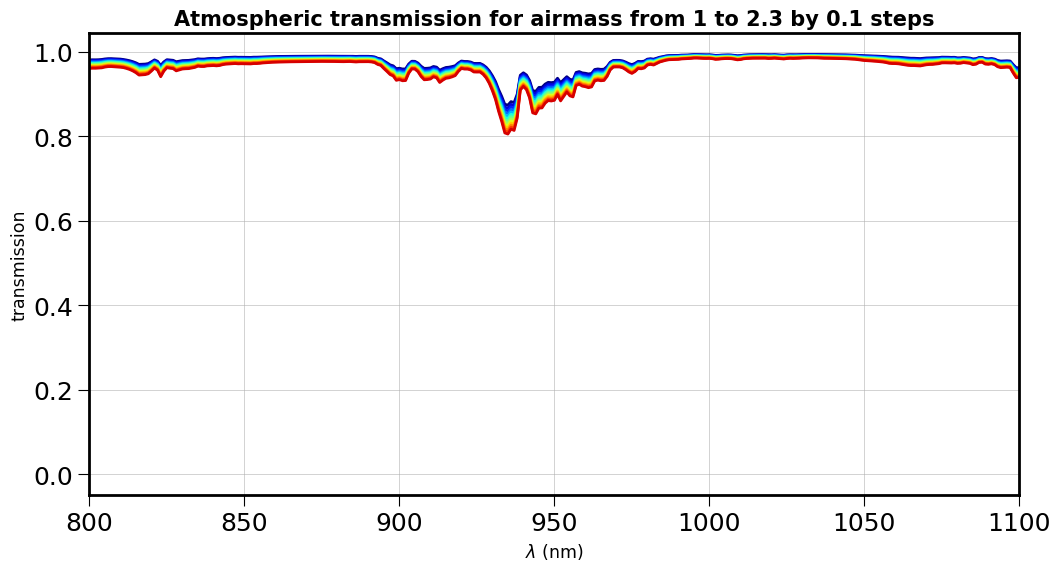

In [8]:
if True:
    for index in np.arange(NBOBS):   
        plt.plot(wl,all_trans[index],'-',color=all_colors[index])
    plt.xlim(300,1200)
    plt.grid()
    plt.title(f"Atmospheric transmission for airmass from {AMMIN} to {AMMAX} by {AMSTEP} steps")
    plt.xlabel("$\\lambda$ (nm)")
    plt.ylabel("transmission")
    #plt.ylim(0.5,1)
    plt.xlim(800.,1100.)
    figname="multitransmission.png"
    plt.savefig(figname)

In [9]:
ids, airmasses, pressures, eqwidths, eqw_errs = np.loadtxt(os.path.join(outdir,'eqw_data_20220629_FELH0600_holo4_003.txt'), skiprows=1, unpack=True)
ids1, airmasses1, pressures1, eqwidths1, eqw_errs1 = np.loadtxt(os.path.join(outdir,'eqw_data_20220630_FELH0600_holo4_003.txt'), skiprows=1, unpack=True)
print(len(ids), len(ids1))
gaussianLimits = lims #determined on observations
print(gaussianLimits)
print(min_wl, max_wl)

28 28
[ 873.43309243  900.50884649  984.03899141 1011.38037742]
870.0 1040.0


8 7 7 7
[0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3] [ 6 10  2  5  4  1  0]


/home/joseph/AuxtelEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/joseph/AuxtelEnv/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/joseph/AuxtelEnv/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/joseph/AuxtelEnv/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/joseph/AuxtelEnv/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


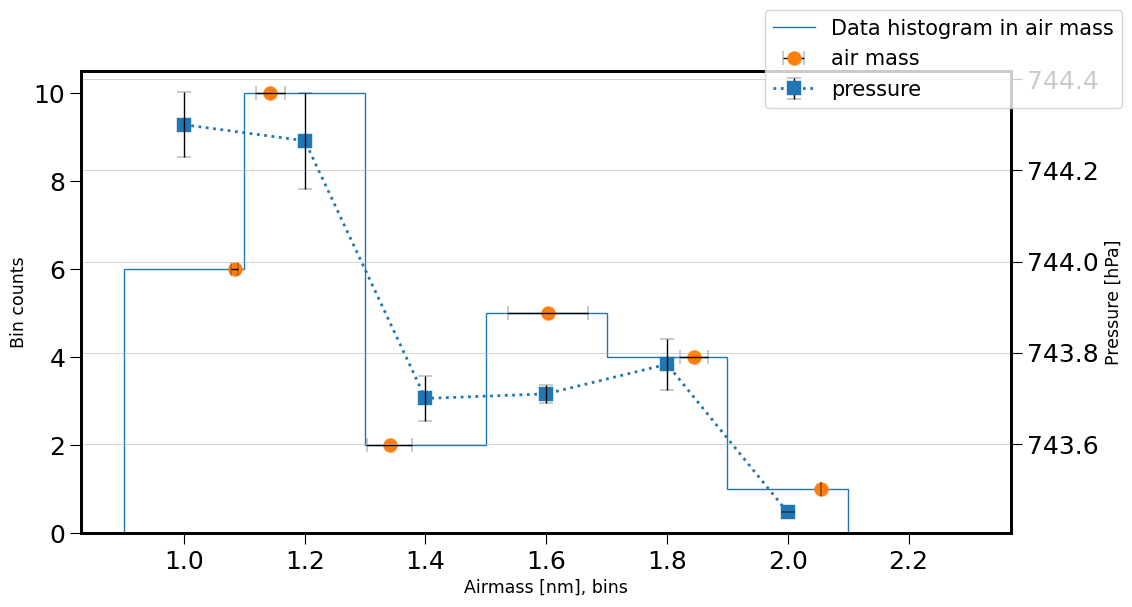

In [10]:
bounds, counts, amMeans, amErrs, pressMeans, pressErrs = bin_data(airmasses, pressures)
print(len(bounds), len(counts), len(amMeans), len(amErrs))
print(bounds, counts)
f,a0 = plt.subplots(1,1)
a1=a0.twinx()
a0.stairs(counts, bounds, label="Data histogram in air mass")
a0.errorbar(amMeans, counts, xerr=amErrs, barsabove=True, ls='', marker='o', label="air mass", ecolor='k', elinewidth=1, capsize=5)
a1.errorbar((bounds[:-1]+bounds[1:])/2, pressMeans, yerr=pressErrs, barsabove=True, ls=':', marker='s', label="pressure", ecolor='k', elinewidth=1, capsize=5)
a1.grid()
a0.set_xlabel("Airmass [nm], bins")
a0.set_ylabel("Bin counts")
a1.set_ylabel("Pressure [hPa]")
f.legend()
#plt.bar((bounds[:-1]+bounds[1:])/2, counts, width=.1)

8 7 7 7
[0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3] [6 8 3 2 5 3 1]


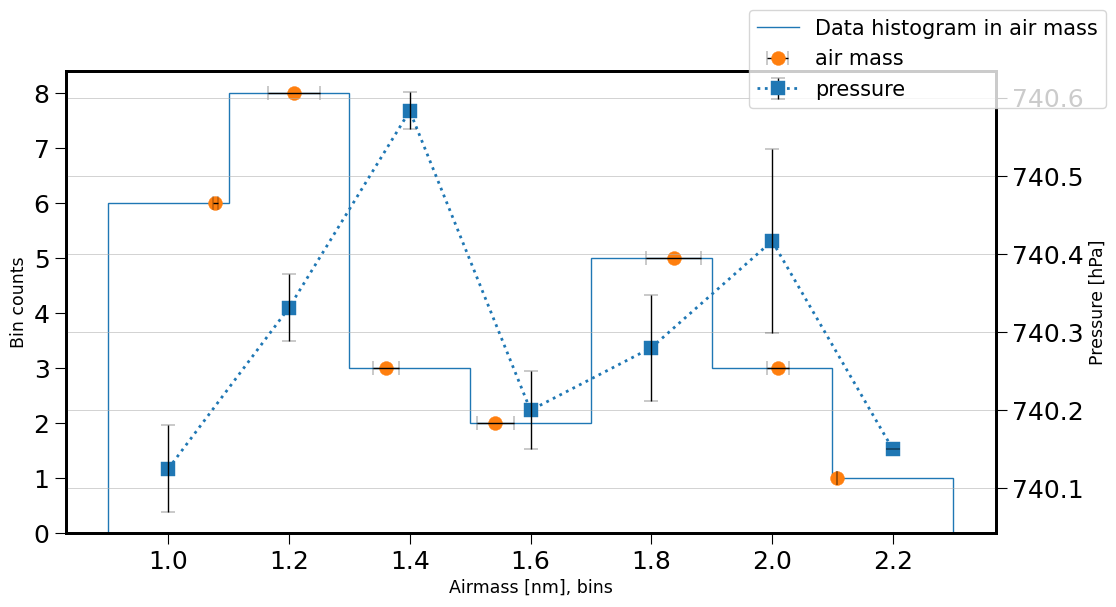

In [11]:
bounds1, counts1, amMeans1, amErrs1, pressMeans1, pressErrs1 = bin_data(airmasses1, pressures1)
print(len(bounds1), len(counts1), len(amMeans1), len(amErrs1))
print(bounds1, counts1)
f,a0 = plt.subplots(1,1)
a1=a0.twinx()
a0.stairs(counts1, bounds1, label="Data histogram in air mass")
a0.errorbar(amMeans1, counts1, xerr=amErrs1, barsabove=True, ls='', marker='o', label="air mass", ecolor='k', elinewidth=1, capsize=5)
a1.errorbar((bounds1[:-1]+bounds1[1:])/2, pressMeans1, yerr=pressErrs1, barsabove=True, ls=':', marker='s', label="pressure", ecolor='k', elinewidth=1, capsize=5)
a1.grid()
a0.set_xlabel("Airmass [nm], bins")
a0.set_ylabel("Bin counts")
a1.set_ylabel("Pressure [hPa]")
f.legend()
#plt.bar((bounds[:-1]+bounds[1:])/2, counts, width=.1)

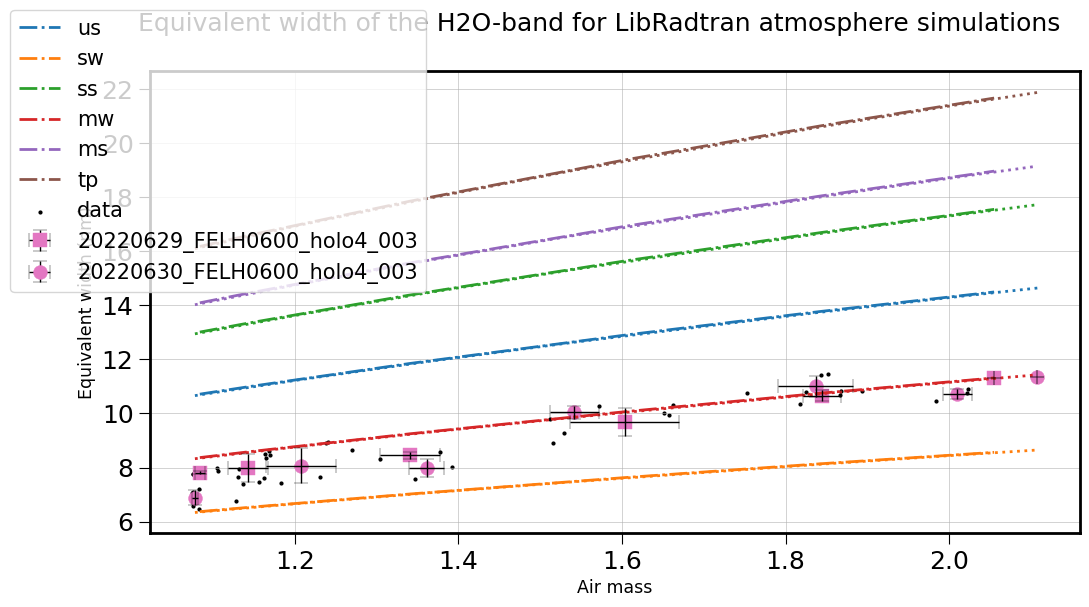

In [13]:
if True:
    fig, ax = plt.subplots(1,1)
    #for p, m in zip([1.0, 2.0, 4.0, 6.0, 8.0], ['*', 'x', '.', '+', '1']):
    atmosEQWS_listOfArrays = simAtmEqw(amMeans[counts>0], pressMeans[counts>0], wl_min=min_wl, wl_max=max_wl, wl_mid=h2o_line, lims=gaussianLimits, pwv=-1.0, oz=-1.0, atm='all', inter='sa', clouds=0.0, flagVerbose=False)
    for atmType,c in zip(atmosEQWS_listOfArrays[0][:,0], ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']):
        list_eqw_type = []
        for j in np.arange(len(amMeans[counts>0])):
            list_eqw_type.append(float(atmosEQWS_listOfArrays[j][atmosEQWS_listOfArrays[j][:,0] == atmType, 1][0]))
        #if p == 1.:
            lab=atmType
        #else:
        #    lab=''
        ax.plot(amMeans[counts>0], list_eqw_type, label=lab, ls='-.', color=c)
        
    atmosEQWS_listOfArrays = simAtmEqw(amMeans1[counts1>0], pressMeans1[counts1>0], wl_min=min_wl, wl_max=max_wl, wl_mid=h2o_line, lims=gaussianLimits, pwv=-1.0, oz=-1.0, atm='all', inter='sa', clouds=0.0, flagVerbose=False)
    for atmType,c in zip(atmosEQWS_listOfArrays[0][:,0], ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']):
        list_eqw_type = []
        for j in np.arange(len(amMeans1[counts1>0])):
            list_eqw_type.append(float(atmosEQWS_listOfArrays[j][atmosEQWS_listOfArrays[j][:,0] == atmType, 1][0]))
        #if p == 1.:
            lab=''
        #else:
        #    lab=''
        ax.plot(amMeans1[counts1>0], list_eqw_type, label=lab, ls=':', color=c)
        
    _dum0, _dum1, _dum2, _dum3, eqwMeans, eqwErrs = bin_data(airmasses, eqwidths)
    _dum0, _dum1, _dum2, _dum3, eqwMeans1, eqwErrs1 = bin_data(airmasses1, eqwidths1)
        
    ax.errorbar(amMeans, eqwMeans, xerr=amErrs, yerr=eqwErrs, barsabove=True, label="20220629_FELH0600_holo4_003", color="tab:pink", ls='', marker="s", ecolor='k', elinewidth=1, capsize=5)
    ax.errorbar(amMeans1, eqwMeans1, xerr=amErrs1, yerr=eqwErrs1, barsabove=True, label="20220630_FELH0600_holo4_003", color="tab:pink", ls='', marker="o", ecolor='k', elinewidth=1, capsize=5)
    ax.scatter(np.append(airmasses,airmasses1), np.append(eqwidths,eqwidths1), color='k', marker='.', s=16, label='data')
    ax.set_xlabel("Air mass")
    ax.set_ylabel("Equivalent width (nm)")
    ax.grid()
    fig.legend(loc="upper left")
    fig.suptitle("Equivalent width of the H2O-band for LibRadtran atmosphere simulations")